# Anime Recommendation System Project

## Imported Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import random
from random import randint

import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
#from sklearn.preprocessing import MinMaxScalerort sklearn as skl

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.prediction_algorithms import knns
from surprise.prediction_algorithms import SVD
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy
from surprise import Reader
from surprise import Dataset

ModuleNotFoundError: No module named 'pandas'

## Datasets

#### Main Anime Dataset (anime.csv)

In [3]:
anime_main = pd.read_csv("data/anime.csv")

#### Anime Ratings Dataset (rating_complete.csv)

In [4]:
anime_ratings = pd.read_csv("data/rating_complete.csv")

In [5]:
print(anime_main.shape)
print(anime_main.columns.unique())
anime_main.head()

(17562, 35)
Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')


,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [6]:
print(anime_ratings.shape)
print(anime_ratings.columns.unique())
anime_ratings.head()

(57633278, 3)
Index(['user_id', 'anime_id', 'rating'], dtype='object')


,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


## Dataset Cleaning and Merging

In [7]:
# Clean main anime dataset and keep necessary features
anime_main = anime_main[['MAL_ID', 'Name', 'Score', 'Genres', 'Type', 'Episodes']]
anime_main.dropna(inplace=True)

print(anime_main.shape)
print(anime_main.columns)
anime_main.head()

(17562, 6)
Index(['MAL_ID', 'Name', 'Score', 'Genres', 'Type', 'Episodes'], dtype='object')


,MAL_ID,Name,Score,Genres,Type,Episodes
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Movie,1
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",TV,26
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",TV,26
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",TV,52


In [20]:
# Reduce size of ratings dataset by sampling
print(anime_ratings.shape)

(57633278, 3)


In [9]:
# Rename columns and merge datasets
anime_main = anime_main.rename(columns={'MAL_ID': 'Anime ID'})
anime_ratings = anime_ratings.rename(columns={'user_id': 'User ID', 'anime_id': 'Anime ID', 'rating': 'Rating'})
anime_df = pd.merge(anime_main, anime_ratings, on='Anime ID')

In [10]:
print(anime_df.shape)
print(anime_df.columns)
anime_df.head()

(57633278, 8)
Index(['Anime ID', 'Name', 'Score', 'Genres', 'Type', 'Episodes', 'User ID',
       'Rating'],
      dtype='object')


,Anime ID,Name,Score,Genres,Type,Episodes,User ID,Rating
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,3,9
1,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,6,6
2,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,14,9
3,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,19,8
4,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,22,9


## Data Visualizations

<AxesSubplot:xlabel='Type', ylabel='count'>

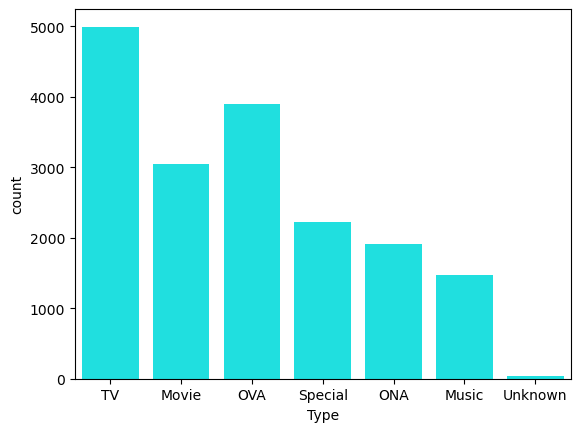

In [11]:
sns.countplot(x='Type', data=anime_main, color='cyan')

OVA = Original Video Animation, ONA = Original Net Animation

<AxesSubplot:xlabel='Rating', ylabel='count'>

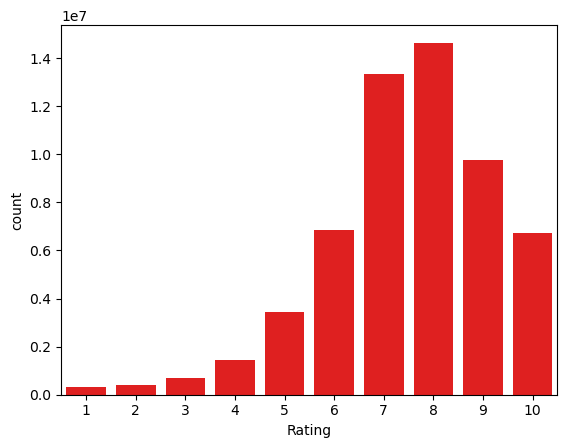

In [12]:
sns.countplot(x='Rating', data=anime_ratings, color='red')

In [1]:
# unique Genre values
genres = anime_main['Genres']
genres = pd.DataFrame([sub.split(",") for sub in genres])
pd.unique(genres.values.ravel('K'))

NameError: name 'anime_main' is not defined

In [2]:
%pip install surprise

  Using cached surprise-0.1-py2.py3-none-any.whl (1.8 kB)
  Using cached scikit-surprise-1.1.3.tar.gz (771 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for scikit-surprise
Failed to build scikit-surprise
  Running setup.py install for scikit-surprise: started
  Running setup.py install for scikit-surprise: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [76 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-39
      creating build\lib.win-amd64-cpython-39\surprise
      copying surprise\accuracy.py -> build\lib.win-amd64-cpython-39\surprise
      copying surprise\builtin_datasets.py -> build\lib.win-amd64-cpython-39\surprise
      copying surprise\dataset.py -> build\lib.win-amd64-cpython-39\surprise
      copying surprise\dump.py -> build\lib.win-amd64-cpython-39\surprise
      copying surprise\reader.py -> build\lib.win-amd64-cpython-39\surprise
      copying surprise\trainset.py -> build\lib.win-amd64-cpython-39\surprise
      copying surprise\utils.py -> build\lib.win-amd64-cpython-39\surprise
      copying surprise\__init__.py -> build\lib.win-amd64-cpython-39\surprise
      copying surprise\__main__.py -> build\

In [21]:
# SVD model
#from surprise import SVD
#from surprise.model_selection import cross_validate

In [3]:
%pip install implicit

     -------------------------------------- 647.2/647.2 kB 4.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# ALS model
import implicit

def create_data(datapath,start_date,end_date):
    df = pd.read_csv(datapath)
    df = df.assign(date = pd.Series(datetime.fromtimestamp(a/1000).date()
                   for a in df.timestamp))
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)

### Tensorflow SVD Test

In [ ]:
# anime_main
# anime_ratings

%pip install tensorflow
import tensorflow as tf

# Old SVD Code

In [17]:
animeList = anime_main
animeRatings = anime_ratings

In [18]:
print(animeList.columns)
print(animeRatings.columns)

Index(['Anime ID', 'Name', 'Score', 'Genres', 'Type', 'Episodes'], dtype='object')
Index(['User ID', 'Anime ID', 'Rating'], dtype='object')


In [19]:
animeRatings = animeRatings.sample(n=5000)
animeRatings.shape

(5000, 3)

In [24]:
# #Create Ratings Matrix
# ratings_mat = np.ndarray(
#     shape=(np.max(data.movie_id.values), np.max(data.user_id.values)),
#     dtype=np.uint8)
# ratings_mat[data.movie_id.values-1, data.user_id.values-1] = data.rating.values

#Create Ratings Matrix
ratingsMat = np.ndarray(shape = (np.max(animeRatings['Anime ID'].values), np.max(animeRatings['User ID'].values)), dtype = np.uint8) 
ratingsMat[animeRatings['Anime ID'].values-1, animeRatings['User ID'].values-1] = animeRatings['Rating'].values

MemoryError: Unable to allocate 14.5 GiB for an array with shape (44044, 353395) and data type uint8

In [ ]:
#Normalize animeRating matrix
normalized_Ratings = ratingsMat - np.asarray([(np.mean(ratingsMat, 1))]).T
#Compute the SVD
A = normalized_Ratings.T / np.sqrt(ratingsMat.shape[0] - 1)
U, S, V = np.linalg.svd(A)

#Define a function to calculate cosine similarity
def topSimiliar(data, anime_id, top_n=10):
    index = anime_id - 1 
    anime_row = data[index, :]
    magnitude = np.sqrt(np.einsum('ij, ij -> i', data, data))
    similarity = np.dot(anime_row, data.T) / (magnitude[index] * magnitude)
    sort_Index = np.argsort(-similarity)
    return sort_Index[:top_n]

In [ ]:
def printSimiliarAnime(animeList, animeID, numIndexes):
    print('Recommendatinos for {0}:\n'.format
        ( animeList[animeList.MAL_ID == animeID].Name.values[0] )
    )
    for iD in numIndexes + 1:
        print(animeList[animeList.MAL_ID == animeID].name.values[0])

In [ ]:
#Test
k = 50
animeID = 10
numIndexes = 10
sliced = V.T[:,:k]
indexes = topSimiliar(sliced,animeID,numIndexes)

printSimiliarAnime(animeList, animeID, indexes)

## New SVD Model

In [ ]:
anime_sample = anime_df.sample(n=7500)0